In [1]:
import sys

sys.path.append('../../')

import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities, DiamondNorm, Kron_Choi
from utils_qiskit import results2dict, save_results
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from QuantumTomography import RandomUnitary

In [2]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')

In [3]:
backend = provider.get_backend('ibm_nairobi')
simulator = Aer.get_backend('aer_simulator')
job_manager = IBMQJobManager()


In [4]:
# 0-1-2
#   3
# 4-5-6

parall_qubits_all = [   [(1,3)],
                    [(3,5)],
                    [(0,3)],
                    [(2,3)],
                    [(3,4)],
                    [(3,6)],
                    ] 

In [5]:
# ibm_lagos
job_ids = [
['da8e16ea5bd3495188ee2d1c0ea6c643-166250463225726',
'b86876eb77b24a17b38e7891fd0b0d74-1662504635643602',
'8318ed4ecbd24beca0ecd01c9b4dbdee-16625046389304116',
'98a3b971069549ea956a3907cf7905f9-16625046423653195',
'b16d40ca0b1542d5bbabf4d7a72ee562-16625046457092187',
'1d74ff22f4d44f94bfff1f20b60d588a-16625046490846372'],
['6a07bcb4d6824823b8bbc44162c0af44-16638019765235069',
'dc4d8c470c5246e0b521ebbcf08ea1af-16638019803554642',
'e1970f1afd1c471cbb8e88db232ff8ea-16638019839696832',
'954d89487d4346daaa9ef863e3b61a1c-16638019875378263',
'0a8e1f5a820b4c62bafc88ea7c7294b3-1663801991228174',
'3ea4e381deb14215b6e4d332525c6443-16638019951631215'],
['d60e960169f34b018cc3c82166059add-16638020101953256',
'f0b9ba762fc1449a9cd501259ae9b89d-166380201400181',
'747d5e3c2d2848ad9fdb26cfbd2fa6fa-16638020177348197',
'd13f7d6870994e2e9d1e86c97e892b3c-16638020217573638',
'cbf541baf786412aadfe8aaf0d813dd4-16638020250914996',
'1e5d9fe95e724fcbbc4724d84c84c6f2-1663802028890298'],
['39744415cf094561b366df8ad3fd5647-16638020570513034',
'cc939cb885014956b211f2f185084e99-16638020609091',
'0b8f6f8ab1124d7998b63d1f793efaa5-16638020645882363',
'042e40226ad34da3ad033d7216a66f83-16638020679859169',
'139750d555ea47d696fab3ad18f036a9-16638020719078918',
'f3ac438091c542858aef46117146a426-1663802075937487'],
['b2fde4ae0d744076b69917ed4cc4528d-16638021103086042',
'7cfe7f60bdc844fe9d91c3029788bd3b-1663802114219709',
'df76d0f90b744676815b052cd2538797-16638021181812916',
'36292cde76154a358f4473e50eb990db-16638021221160228',
'f96626906f7c410fa04dc16f4f76f442-16638021257954683',
'b1444d28a5e64eeb8ee2fc7178bc16f5-1663802129771422']
]

In [6]:
# results_tomo_mc = []

# for job_id in job_ids:

#     results_tomo = []

#     for j in range(len(job_id)) :                                                  
#         qndmt = device_process_measurement_tomography( backend, parall_qubits=[parall_qubits_all[j]] )
#         circuits_qndmt = qndmt.circuits()                                         
    
#         job = job_manager.retrieve_job_set( job_id[j], provider )                  
#         results = job.results().combine_results()                                 
#         save_results( results, name = job_id[j], folder = 'data_correlations')     
#         results_tomo.append( qndmt.fit( results, paralell=True, gate_set=True ) )  

#     results_tomo_mc.append( results_tomo )

In [7]:
# np.save( 'data_correlations/results_tomography', np.array(results_tomo_mc, dtype=object) )

In [8]:
results_tomo_mc = np.load('data_correlations/results_tomography.npy', allow_pickle=True )

In [9]:
quantities_mc = []
correlations_mc = []
for k in range(5):
    quantities = []
    correlations = []
    for j in range(6) :
        chois_single = results_tomo_mc[k][j].single.chois 
        povms_single = results_tomo_mc[k][j].single.povms
        chois_double = results_tomo_mc[0][0].double[0].chois
        povms_double = results_tomo_mc[0][0].double[0].povms

        Qs = [ Quantities( povms_single[0], chois_single[0]  ),
                Quantities( povms_single[1], chois_single[1] ),
                Quantities( povms_double[0], chois_double[0]  ) ]

        quantities.append( Qs )

        Qs = Cross_Quantities( povms_single[0], chois_single[0],
                                povms_single[1], chois_single[1],
                                povms_double[0], chois_double[0]
                            )
        correlations.append( Qs )
    quantities_mc.append( quantities )
    correlations_mc.append( correlations )

In [10]:
rFs_mc = []
for m in range(5):
    rFs = []
    for j in range(6):
        F0  = quantities_mc[m][j][0][0]
        F1  = quantities_mc[m][j][1][0]
        F01 = quantities_mc[m][j][2][0]
        rF  = abs(F01 - F0*F1) #/(F0*F1) 
        rFs.append( rF )
    rFs_mc.append( rFs )

rQs_mc = []
for m in range(5):
    rQs = []
    for j in range(6):
        Q0  = quantities_mc[m][j][0][1]
        Q1  = quantities_mc[m][j][1][1]
        Q01 = quantities_mc[m][j][2][1]
        rQ  = abs( Q01 - Q0*Q1 ) #/( Q0*Q1 ) 
        rQs.append( rQ )
    rQs_mc.append( rQs )

No handles with labels found to put in legend.


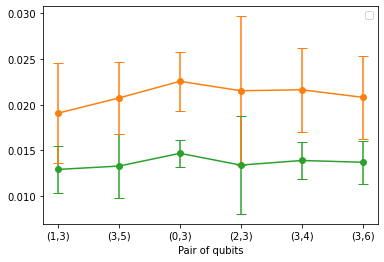

In [18]:
cF = np.mean( rFs_mc, axis=0 )
dcF = np.std( rFs_mc, axis=0 )

cQ = np.mean( rQs_mc, axis=0 )
dcQ = np.std( rQs_mc, axis=0 )

plt.errorbar( x=range(6), y=cF, yerr=dcF, fmt='-o', capsize=5, color='tab:green' )
plt.errorbar( x=range(6), y=cQ, yerr=dcQ, fmt='-o', capsize=5, color='tab:orange' )
plt.xticks( range(6), labels=[ '(1,3)', '(3,5)', '(0,3)', '(2,3)', '(3,4)', '(3,6)' ])
plt.legend()
plt.xlabel( 'Pair of qubits' )
plt.savefig('correlations_error_qubit3_distance2.png', bbox_inches='tight' )
plt.savefig('correlations_error_qubit3_distance2.svg', bbox_inches='tight' ) 

In [12]:
F = np.mean(correlations_mc,0)
DF = np.std(correlations_mc,0)

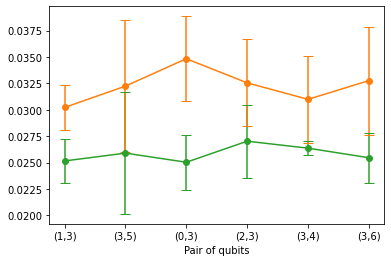

In [20]:
plt.errorbar( range(6), F[:,0], yerr=DF[:,0], fmt='-o', capsize=5, label='$C[\Pi]$', color='tab:green' )
plt.errorbar( range(6), F[:,1], yerr=DF[:,1], fmt='-o', capsize=5, label='$C[Y]$', color='tab:orange' )
plt.xticks( range(6), labels=['(1,3)','(3,5)','(0,3)','(2,3)','(3,4)','(3,6)'])
plt.xlabel( 'Pair of qubits' )
plt.savefig('correlations_operators_qubit3_distance2.png', bbox_inches='tight' )
plt.savefig('correlations_operators_qubit3_distance2.svg', bbox_inches='tight' ) 

In [14]:
# diamond_mc = []
# for k in range(5):
#     diamond = []
#     for j in range(6) :
#         chois_single = results_tomo_mc[k][j].single.chois 
#         povms_single = results_tomo_mc[k][j].single.povms
#         chois_double = results_tomo_mc[0][0].double[0].chois
#         povms_double = results_tomo_mc[0][0].double[0].povms
#         chois_single_kron = Kron_Choi( chois_single[0], chois_single[1] )
#         Ds = 0.25*( DiamondNorm( chois_double[0][0], chois_single_kron[0], 'vec'  ) 
#                     + DiamondNorm( chois_double[0][1], chois_single_kron[1], 'vec'  ) 
#                     + DiamondNorm( chois_double[0][2], chois_single_kron[2], 'vec'  ) 
#                     + DiamondNorm( chois_double[0][3], chois_single_kron[3], 'vec'  ) 
#                     )
#         diamond.append( Ds )
#     diamond_mc.append( diamond )


In [15]:
# F = np.mean(diamond_mc,0)
# DF = np.std(diamond_mc,0)
# plt.errorbar( range(6), F, yerr=DF, fmt='-o', capsize=5, label='$C[Y]$' )
# plt.xticks( range(6), labels=['(1,3)[1]','(3,5)[1]','(0,3)[2]','(2,3)[2]','(3,4)[2]','(3,6)[2]'])
# plt.legend()